In [1]:
from pathlib import Path

In [2]:
utci_path = Path("/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg/")
for model_path in utci_path.glob("*"):
    model = str(model_path).split('/')[-1]
    for scenario_path in model_path.glob("*"):
        scenario = str(scenario_path).split('/')[-1]
        for runid_path in scenario_path.glob("*"):
            runid = str(runid_path).split('/')[-1]
            print(model, scenario, runid)
            break
        break
    break

ERROR! Session/line number was not unique in database. History logging moved to new session 1315
HadGEM3-GC31-LL historical r1i1p1f3


In [3]:
utci_path = Path("/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg/")

file_nested_list = []
model_list = []
scenario_list = []
runid_list = []


for model_path in utci_path.glob("*"):
    model = str(model_path).split('/')[-1]
    model_list.append(model)
    file_nested_list.append([])
    for scenario_path in model_path.glob("*"):
        scenario = str(scenario_path).split('/')[-1]
        scenario_list.append(scenario)
        file_nested_list[-1].append([])
        for runid_path in scenario_path.glob("*"):
            runid = str(runid_path).split('/')[-1]
            runid_list.append(runid)
            
            print(model, scenario, runid)
            file_nested_list[-1][-1].append(list(runid_path.glob("*")))
    break


HadGEM3-GC31-LL historical r1i1p1f3
HadGEM3-GC31-LL ssp126 r1i1p1f3
HadGEM3-GC31-LL ssp245 r1i1p1f3
HadGEM3-GC31-LL ssp585 r1i1p1f3


In [4]:
import xarray as xr

In [5]:
ds = xr.open_mfdataset(file_nested_list, combine='nested', engine='h5netcdf', concat_dim=['time', 'runid', 'scenario', 'model'])

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
Exception ignored in: <function CachingFileManager.__del__ at 0x7f6fe802aaf0>
Traceback (most recent call last):
  File "/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/backends/file_manager.py", line 244, in __del__
distributed.nanny - WARNING - Restarting worker
    self.close(needs_lock=False)
  File "/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/backends/file_manager.py", line 222, in close
    file.close()
  File "/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/h5netcdf/core.py", line 879, in close
    self._h5file.close()
  File "/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/h5py/_hl/files.py", line 471, in close
    h5i.dec_ref

Traceback (most recent call last):
  File "/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/backends/file_manager.py", line 199, in _acquire_with_cache_info
    file = self._cache[self._key]
  File "/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/backends/lru_cache.py", line 53, in __getitem__
    value = self._cache[key]
KeyError: [<class 'h5netcdf.core.File'>, ('/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg/HadGEM3-GC31-LL/ssp245/r1i1p1f3/utci_3hr_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_208001010300-208101010000.nc',), 'r', (('decode_vlen_strings', True), ('invalid_netcdf', None))]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-a148f

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker

KeyboardInterrupt



In [ ]:
utci_path = Path("/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg/")

file_nested_list = []
model_list = []
scenario_list = []
runid_list = []


for model_path in utci_path.glob("*"):
    model = str(model_path).split('/')[-1]
    model_list.append(model)
    file_nested_list.append([])
    for scenario_path in model_path.glob("*"):
        scenario = str(scenario_path).split('/')[-1]
        scenario_list.append(scenario)
        file_nested_list[-1].append([])
        for runid_path in scenario_path.glob("*"):
            runid = str(runid_path).split('/')[-1]
            runid_list.append(runid)
            
            print(model, scenario, runid)
            files = list(runid_path.glob("*"))
            file_nested_list[-1][-1].append(files)
            ds = xr.open_mfdataset(files, concat_dim='time')
            
            # Now break, and we will re-loop it later
        break
    break


In [ ]:
ds

In [ ]:
# Take monthly averages
ds_monthly = ds.resample(time='M').mean()

In [ ]:
ds_monthly

In [ ]:
utci_path = Path("/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg/")

file_nested_list = []
model_list = []
scenario_list = []
runid_list = []


for model_path in utci_path.glob("*"):
    model = str(model_path).split('/')[-1]
    model_list.append(model)
    file_nested_list.append([])
    
    # Get the historical dataset
    ds_historical = xr.open_mfdataset(
        model_path.glob("historical/*/*.nc"),
        concat_dim='time',
    )
    
    # Get the scenario datasets
    for scenario_path in model_path.glob("*"):
        scenario = str(scenario_path).split('/')[-1]
        scenario_list.append(scenario)
        file_nested_list[-1].append([])
        for runid_path in scenario_path.glob("*"):
            runid = str(runid_path).split('/')[-1]
            runid_list.append(runid)
            
            print(model, scenario, runid)
            files = list(runid_path.glob("*"))
            file_nested_list[-1][-1].append(files)
            ds = xr.open_mfdataset(files, concat_dim='time')
            
            # Now break, and we will re-loop it later
        break
    break


In [1]:
from pathlib import Path
import xarray as xr

utci_path = Path(
    "/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg/"
)

file_nested_list = []
model_list = []
scenario_list = []
runid_list = []


for model_path in utci_path.glob("*"):
    model = str(model_path).split("/")[-1]
    model_list.append(model)
    file_nested_list.append([])
        
    scenario_ds = {}
    
    # Get the scenario datasets
    for scenario_path in model_path.glob("*"):
        scenario = str(scenario_path).split("/")[-1]
        scenario_list.append(scenario)
        file_nested_list[-1].append([])
        
        for runid_path in scenario_path.glob("*"):
            runid = str(runid_path).split("/")[-1]
            runid_list.append(runid)

            print(model, scenario, runid)
            files = list(runid_path.glob("*"))
            file_nested_list[-1][-1].append(files)

            scenario_ds[scenario] = xr.open_mfdataset(files, concat_dim="time")

            # Now break, and we will re-loop it later
            break # there should be only one runid at this point...
        
    break

HadGEM3-GC31-LL historical r1i1p1f3
HadGEM3-GC31-LL ssp126 r1i1p1f3
HadGEM3-GC31-LL ssp245 r1i1p1f3
HadGEM3-GC31-LL ssp585 r1i1p1f3


In [2]:
scenario_ds

{'historical': <xarray.Dataset>
 Dimensions:   (bnds: 2, lat: 180, lon: 360, time: 86400)
 Coordinates:
   * time      (time) object 1985-01-01 03:00:00 ... 2015-01-01 00:00:00
   * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
   * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
 Dimensions without coordinates: bnds
 Data variables:
     utci      (time, lat, lon) float64 dask.array<chunksize=(2880, 180, 360), meta=np.ndarray>
     lat_bnds  (time, lat, bnds) float64 dask.array<chunksize=(2880, 180, 2), meta=np.ndarray>
     lon_bnds  (time, lon, bnds) float64 dask.array<chunksize=(2880, 360, 2), meta=np.ndarray>
 Attributes:
     Conventions:  CF-1.7,
 'ssp126': <xarray.Dataset>
 Dimensions:   (bnds: 2, lat: 180, lon: 360, time: 247680)
 Coordinates:
   * time      (time) object 2015-01-01 03:00:00 ... 2101-01-01 00:00:00
   * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
   * lon       (lon) float64 -179.5

In [3]:
climatology = scenario_ds['historical'].groupby('time.month').mean()

In [4]:
def subtract_climatology(ds, climatology):
    return ds.groupby('time.month') - climatology

def decadal_average(ds):
    return ds.resample(time='10Y').mean().groupby('time.year').max()

In [5]:
from tqdm import tqdm

In [6]:
scratch_path = Path("/work/scratch-pw/champs/hackathon")
scratch_path.mkdir(exist_ok=True)

In [9]:
# This takes a long time
for scenario in tqdm(scenario_ds):
    out_path = scratch_path / model / scenario / runid / "monthly_avg.nc"
    out_path.parent.mkdir(parents=True, exist_ok=True)
    (scenario_ds[scenario].resample(time="M").mean()).to_netcdf(out_path)

100%|██████████| 4/4 [1:01:27<00:00, 921.97s/it] 


In [ ]:
# Get the GMST for the same models
badc_path = Path("/badc/cmip6/data/CMIP6/CMIP/MOHC/HadGEM3-GC31-LL/ssp585")

In [19]:
import xarray as xr
from pathlib import Path
scratch_path = Path("/work/scratch-pw/champs/hackathon")
from tqdm import tqdm

utci_path = Path("/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly/")

file_nested_list = []
model_list = []
scenario_list = []
runid_list = []


for model_path in utci_path.glob("*"):
    model = str(model_path).split('/')[-1]
    model_list.append(model)
    file_nested_list.append([])
    for scenario_path in model_path.glob("*"):
        scenario = str(scenario_path).split('/')[-1]
        scenario_list.append(scenario)
        file_nested_list[-1].append([])
        for runid_path in scenario_path.glob("*"):
            runid = str(runid_path).split('/')[-1]
            runid_list.append(runid)
            
            print(model, scenario, runid)
            file_nested_list[-1][-1].append(list(runid_path.glob("*")))
        break


for scenario in tqdm(['historical']):
    out_path = scratch_path / model / scenario / runid / "monthly_avg.nc"
    ds_monthly = xr.open_dataset(out_path)
    break
    

  0%|          | 0/1 [00:00<?, ?it/s]

HadGEM3-GC31-LL historical r1i1p1f3


In [21]:
import regionmask


In [22]:
mask = regionmask.defined_regions.srex.mask(ds_monthly.lat, ds_monthly.lon)

In [23]:
mask.to_dataframe().value_counts()

region
2.0       2800
17.0      1488
15.0      1170
10.0      1122
11.0      1017
18.0      1000
14.0       900
13.0       750
23.0       750
7.0        732
16.0       702
19.0       700
9.0        638
5.0        625
12.0       483
6.0        339
8.0        320
20.0       300
21.0       300
4.0        105
dtype: int64

In [24]:
mask_regions = xr.concat([(mask == r) for r in regionmask.defined_regions.srex.numbers], dim="region")

In [25]:
ds_monthly.weighted(mask_regions).mean(['lat', 'lon'])

/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/home/users/champs/miniconda3/envs

<xarray.Dataset>
Dimensions:   (bnds: 2, region: 26, time: 361)
Coordinates:
  * time      (time) object 1985-01-30 00:00:00 ... 2015-01-30 00:00:00
Dimensions without coordinates: bnds, region
Data variables:
    utci      (time, region) float64 nan 231.5 nan 259.2 ... 287.2 nan nan nan
    lat_bnds  (time, bnds, region) float64 nan 67.0 nan 39.0 ... nan nan nan
    lon_bnds  (time, bnds, region) float64 nan -50.5 nan -88.0 ... nan nan nan

/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/home/users/champs/miniconda3/envs

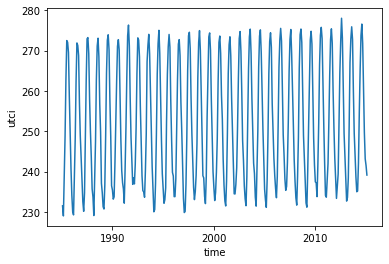

In [27]:
ds_monthly.weighted(mask_regions).mean(['lat', 'lon']).isel(region=1).utci.plot()

In [63]:
# Get the historical baseline
scenario = 'historical'
out_path = scratch_path / model / scenario / runid / "monthly_avg.nc"
ds_monthly = xr.open_dataset(out_path)

ds_baseline = ds_monthly.sel(time=slice('1986', '2016')).weighted(mask_regions).mean(['lat', 'lon', 'time'])
ds_baseline["region"] = [regionmask.defined_regions.srex.abbrevs[i] for i in ds_baseline.region]
    
# Get the scenario means    


/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/home/users/champs/miniconda3/envs

TypeError: list indices must be integers or slices, not DataArray

In [48]:
df = (mask_regions.groupby('region').any(...)).to_dataframe()

In [60]:
# These are the regions that don't get any gridcells selectedd
[regionmask.defined_regions.srex.abbrevs[i] for i, boo in enumerate(df["region"]) if not boo]

['ALA', 'WNA', 'EAS', 'SEA', 'NAU', 'SAU']

In [ ]:
ds_baseline.region

# Day 2
I have resampled the data to monthly.
I need to remember what my task is: a global plot of mean change in UTCI.

In [119]:
import xarray as xr
from pathlib import Path
import baspy as bp

# baspy is a tool used at BAS for keeping track of the CMIP6 data
from tqdm import tqdm

scratch_path = Path("/work/scratch-pw/champs/hackathon")
utci_path = Path(
    "/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly/"
)

file_nested_list = []
model_list = []
scenario_list = []
runid_list = []

# Populate the lists from the directory structure
for model_path in utci_path.glob("*"):
    model = str(model_path).split("/")[-1]
    model_list.append(model)
    file_nested_list.append([])
    for scenario_path in model_path.glob("*"):
        scenario = str(scenario_path).split("/")[-1]
        scenario_list.append(scenario)
        file_nested_list[-1].append([])
        for runid_path in scenario_path.glob("*"):
            runid = str(runid_path).split("/")[-1]
            runid_list.append(runid)

            print(model, scenario, runid)
            file_nested_list[-1][-1].append(list(runid_path.glob("*")))

ds_scenario_results = []
for model in model_list:
    # Get the historical baseline
    scenario = "historical"
    monthly_path = list((scratch_path / model / "historical").glob("*/monthly_avg.nc"))[
        0
    ]
    ds_monthly = xr.open_dataset(monthly_path)

    
    ds_baseline = ds_monthly.resample(time='Y').max().sel(time=slice("1986", "2016")).mean(["time"])

    catlg_sftlf = bp.catalogue(
        dataset="cmip6",
        Var="sftlf",
        Model=model_list,
    ).head(1)
    ds_sftlf = xr.open_dataset(bp.get_files(catlg_sftlf)[0])
    if ds_sftlf.lon.max() > ds_baseline.lon.max():
        ds_sftlf = ds_sftlf.assign_coords(lon=(((ds_sftlf.lon + 180) % 360) - 180))
    ds_sftlf = ds_sftlf.interp(lat=ds_baseline.lat, lon=ds_baseline.lon)

    ds_scenario_results.append([])

    # Get the scenario results
    for scenario in np.unique(scenario_list):
        if scenario == "historical":
            continue
        monthly_path = list((scratch_path / model / scenario).glob("*/monthly_avg.nc"))[
            0
        ]
        ds_monthly = xr.open_dataset(monthly_path)

        ds_scenario_results[-1].append(
            (
                ds_monthly.resample(time='Y').max().sel(time=slice("2035", "2065")).mean("time") - ds_baseline
            ).where(ds_sftlf.sftlf)
        )
        ds_scenario_results[-1][-1] = ds_scenario_results[-1][-1].assign_coords(scenario=[scenario])
        ds_scenario_results[-1][-1] = ds_scenario_results[-1][-1].assign_coords(year=[2050])
        
        ds_scenario_results[-1].append(
            (
                ds_monthly.resample(time='Y').max().sel(time=slice("2070", "2100")).mean("time") - ds_baseline
            ).where(ds_sftlf.sftlf)
        )
        ds_scenario_results[-1][-1] = ds_scenario_results[-1][-1].assign_coords(scenario=[scenario])
        ds_scenario_results[-1][-1] = ds_scenario_results[-1][-1].assign_coords(year=[2085])

    ds_scenario_results[-1] = xr.combine_by_coords(ds_scenario_results[-1])#, dim="scenario")
    ds_scenario_results[-1] = ds_scenario_results[-1].assign_coords(model=[model])

ds_scenario_results = xr.combine_by_coords(ds_scenario_results)#, dim="model")

HadGEM3-GC31-LL historical r1i1p1f3
HadGEM3-GC31-LL ssp126 r1i1p1f3
HadGEM3-GC31-LL ssp245 r1i1p1f3
HadGEM3-GC31-LL ssp585 r1i1p1f3
BCC-CSM2-MR historical r1i1p1f1
BCC-CSM2-MR ssp126 r1i1p1f1
BCC-CSM2-MR ssp245 r1i1p1f1
BCC-CSM2-MR ssp585 r1i1p1f1
CMCC-ESM2 historical r1i1p1f1
CMCC-ESM2 ssp126 r1i1p1f1
CMCC-ESM2 ssp245 r1i1p1f1
CMCC-ESM2 ssp585 r1i1p1f1


In [120]:
ds_scenario_results.utci.attrs = {"long_name": "Change in UTCI", "short_name": "delta_utci", "units": "K"}

/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


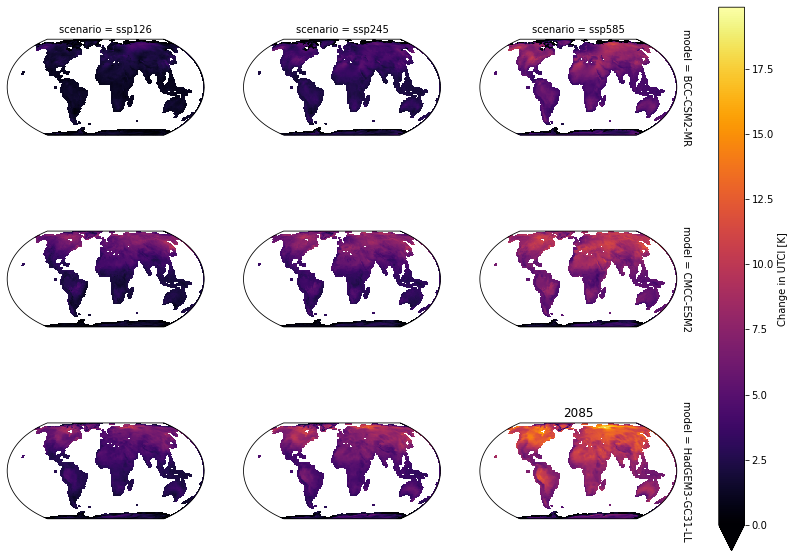

In [125]:
# Plot the maps

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

map_proj = ccrs.EqualEarth()
fg = ds_scenario_results.sel(year=2085).utci.plot(
    transform=ccrs.PlateCarree(),
    figsize=(15,10),
    subplot_kws={'projection': map_proj,},
    cmap='inferno',
    vmin=0,
    row="model", col="scenario",
)
# plt.title("2085") # doesn't work
plt.savefig("../results/facet_meanutci_2085.pdf")
plt.savefig("../results/facet_meanutci_2085.png")

/home/users/champs/miniconda3/envs/hackathon/lib/python3.8/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


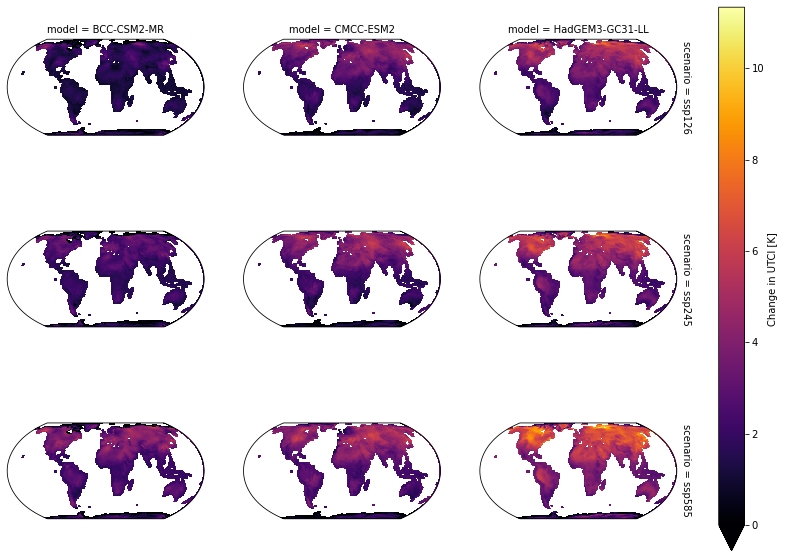

In [123]:
# Plot the maps

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

map_proj = ccrs.EqualEarth()

ds_scenario_results.sel(year=2050).utci.plot(
    figsize=(15,10),
    transform=ccrs.PlateCarree(),
    subplot_kws={'projection': map_proj},
    cmap='inferno',
    vmin=0,
    col="model", row="scenario"
)
# plt.title("2050")  # doesn't work
plt.savefig("../results/facet_meanutci_2050.pdf")
plt.savefig("../results/facet_meanutci_2050.png")

OK, I've done those facet grids, now what?

1. Regions?
2. GMST fit?

In [ ]:
hex_values = ["#A63603", "#E6550D", "#FD8D3C", "#FDAE6B", "#FDD0A2", "#FEEDDE", "#FFFFFF", "#EFF3FF", "#C6DBEF", "#9ECAE1", "#6BAED6",
 "#3182BD", "#08519C"]


## Local results vs GMST

In [48]:
def new_linregress(x, y):
    """Wrapper around scipy linregress to use in apply_ufunc"""
    slope, intercept, r_value, p_value, std_err = stats.linregress(x.flatten(), y.flatten())
    return np.array([slope, intercept, r_value, p_value, std_err])


def fit_parallel_wrapper(
    x: xr.DataArray, y: xr.DataArray, dims = ["time"]
) -> xr.DataArray:
    """Do a linear fit along an axis, independently in other dimensions.
    Different outputs of the fit are arranged along a new dimension, to get
    around the limitation that xr.apply_ufunc can only take a single variable
    output.
    """
    # return a new DataArray
    result = xr.apply_ufunc(
        new_linregress,
        x,
        y,
        input_core_dims=[dims, dims],
        output_core_dims=[["linregress"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=["float64"],
        output_sizes={"parameter": 5},
    )
    result = result.assign_coords(
        {"linregress": ["slope", "intercept", "rvalue", "pvalue", "stderr"]}
    )
    return result

In [114]:
import xarray as xr
from pathlib import Path
import baspy as bp
import numpy as np
from scipy import stats

# baspy is a tool used at BAS for keeping track of the CMIP6 data
from tqdm import tqdm

utci_path = Path(
    "/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg_monthly/"
)

file_nested_list = []
model_list = []
scenario_list = []
runid_list = []

# Populate the lists from the directory structure
for model_path in utci_path.glob("*"):
    model = str(model_path).split("/")[-1]
    model_list.append(model)
    file_nested_list.append([])
    for scenario_path in model_path.glob("*"):
        scenario = str(scenario_path).split("/")[-1]
        scenario_list.append(scenario)
        file_nested_list[-1].append([])
        for runid_path in scenario_path.glob("*"):
            runid = str(runid_path).split("/")[-1]
            runid_list.append(runid)

            print(model, scenario, runid)
            file_nested_list[-1][-1].append(list(runid_path.glob("*")))
            


ds_scenario_results = []
ds_monthly_trends = []
ds_gsat = []
for model in model_list:
    print(model)
    # Get the historical baseline
    scenario = "historical"
    monthly_path = list((utci_path / model / "historical").glob("*/monthly_avg.nc"))[0]
    runid = str(monthly_path).split("/")[-2]
    ds_monthly = xr.open_dataset(monthly_path)

    ds_baseline = (
        ds_monthly
        .sel(time=slice("1986", "2016"))
        .mean(["time"])
    )

    # Get the land fraction
    catlg_sftlf = bp.catalogue(
        dataset="cmip6",
        Var="sftlf",
        Model=model_list,
    ).head(1)
    ds_sftlf = xr.open_dataset(bp.get_files(catlg_sftlf)[0])
    if ds_sftlf.lon.max() > ds_baseline.lon.max():
        ds_sftlf = ds_sftlf.assign_coords(lon=(((ds_sftlf.lon + 180) % 360) - 180))
    ds_sftlf = ds_sftlf.interp(lat=ds_baseline.lat, lon=ds_baseline.lon)

    # Get the (historical) gsat
    catlg_tas = bp.catalogue(
        dataset="cmip6",
        Experiment=scenario,
        CMOR="Amon",
        Var="tas",
        Model=model,
        RunID=runid,
    )
    ds_tas = xr.open_mfdataset(bp.get_files(catlg_tas), combine="by_coords")

    da_area = np.cos(np.deg2rad(ds_tas.lat))
    gsat_historical = ds_tas.tas.weighted(da_area).mean(["lat", "lon", "time"])
    ds_gsat.append([])

    ds_scenario_results.append([])
    

    # Get the scenario results
    for scenario in np.unique(scenario_list):
        print(scenario)
        if scenario == "historical":
            continue
        monthly_path = list((utci_path / model / scenario).glob("*/monthly_avg.nc"))[0]
        ds_monthly = xr.open_dataset(monthly_path)

        utci = (
            (ds_monthly - ds_baseline)
            .where(ds_sftlf.sftlf)
            .assign_coords(scenario=[scenario], model=[model])
        )
        ds_scenario_results[-1].append(utci)

        # Get the (scenario) gsat
        catlg_tas = bp.catalogue(
            dataset="cmip6",
            Experiment=[scenario],
            CMOR="Amon",
            Var="tas",
            Model=[model],
            RunID=[runid],
        )

        ds_tas = xr.open_mfdataset(bp.get_files(catlg_tas), combine="by_coords")

        gsat = (
            ds_tas.tas.weighted(da_area)
            .mean(["lat", "lon"])
            .groupby('time.year')
            .mean()
            .assign_coords(scenario=scenario, model=model)
            .expand_dims(("scenario", "model"))
            - gsat_historical
        ).to_dataset(name='gsat')
        ds_gsat[-1].append(gsat)
#         breakpoint()

    ds_scenario_results[-1] = xr.combine_by_coords(ds_scenario_results[-1])
    ds_gsat[-1] = xr.combine_by_coords(ds_gsat[-1])
    
    monthly_trends = ds_scenario_results[-1].utci.groupby("time.month").apply(
        lambda x: fit_parallel_wrapper(
            ds_gsat[-1].gsat.load(),
            x.groupby("time.year").mean().sel(year=gsat.year).load(),
            ["scenario", "year"],
        )
    )
    ds_monthly_trends.append(monthly_trends)
        

HadGEM3-GC31-LL historical r1i1p1f3
HadGEM3-GC31-LL ssp126 r1i1p1f3
HadGEM3-GC31-LL ssp245 r1i1p1f3
HadGEM3-GC31-LL ssp585 r1i1p1f3
BCC-CSM2-MR historical r1i1p1f1
BCC-CSM2-MR ssp126 r1i1p1f1
BCC-CSM2-MR ssp245 r1i1p1f1
BCC-CSM2-MR ssp585 r1i1p1f1
CMCC-ESM2 historical r1i1p1f1
CMCC-ESM2 ssp126 r1i1p1f1
CMCC-ESM2 ssp245 r1i1p1f1
CMCC-ESM2 ssp585 r1i1p1f1
HadGEM3-GC31-LL
historical
ssp126
ssp245
ssp585


<ipython-input-48-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-48-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-48-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-48-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-48-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direc

BCC-CSM2-MR
historical
ssp126
ssp245
ssp585


<ipython-input-48-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-48-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-48-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-48-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-48-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direc

CMCC-ESM2
historical
ssp126
ssp245
ssp585


<ipython-input-48-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-48-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-48-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-48-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  result = xr.apply_ufunc(
<ipython-input-48-b089a69f15f7>:16: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direc

In [115]:
ds_monthly_trends = xr.concat(ds_monthly_trends, dim='model')

(array([2.17000e+02, 7.63000e+02, 1.37200e+03, 2.51500e+03, 7.32200e+03,
        5.17070e+04, 1.79542e+05, 2.31267e+05, 2.61842e+05, 2.08633e+05]),
 array([-0.80881392, -0.62912671, -0.4494395 , -0.26975229, -0.09006508,
         0.08962213,  0.26930934,  0.44899654,  0.62868375,  0.80837096,
         0.98805817]),
 <BarContainer object of 10 artists>)

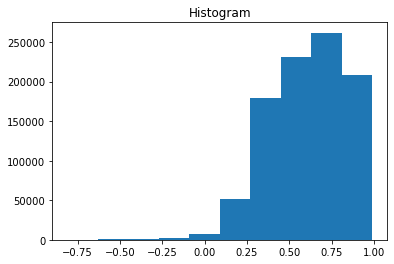

In [116]:
ds_monthly_trends.sel(linregress='rvalue').plot()

(array([ 6493., 44728., 51102., 68386., 63594., 37059., 24539.,  8233.,
         7204.,  3722.]),
 array([-33.08294051, -24.95050542, -16.81807034,  -8.68563525,
         -0.55320017,   7.57923491,  15.71167   ,  23.84410508,
         31.97654016,  40.10897525,  48.24141033]),
 <BarContainer object of 10 artists>)

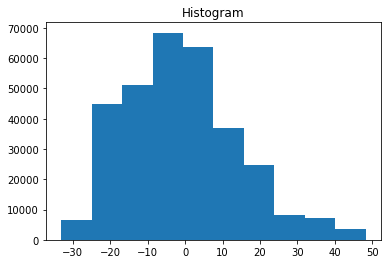

In [129]:
ds_monthly_trends.sel(linregress='intercept').isel(model=0).plot()

In [144]:
ds_monthly_trends.to_netcdf("ds_monthly_trends.nc")

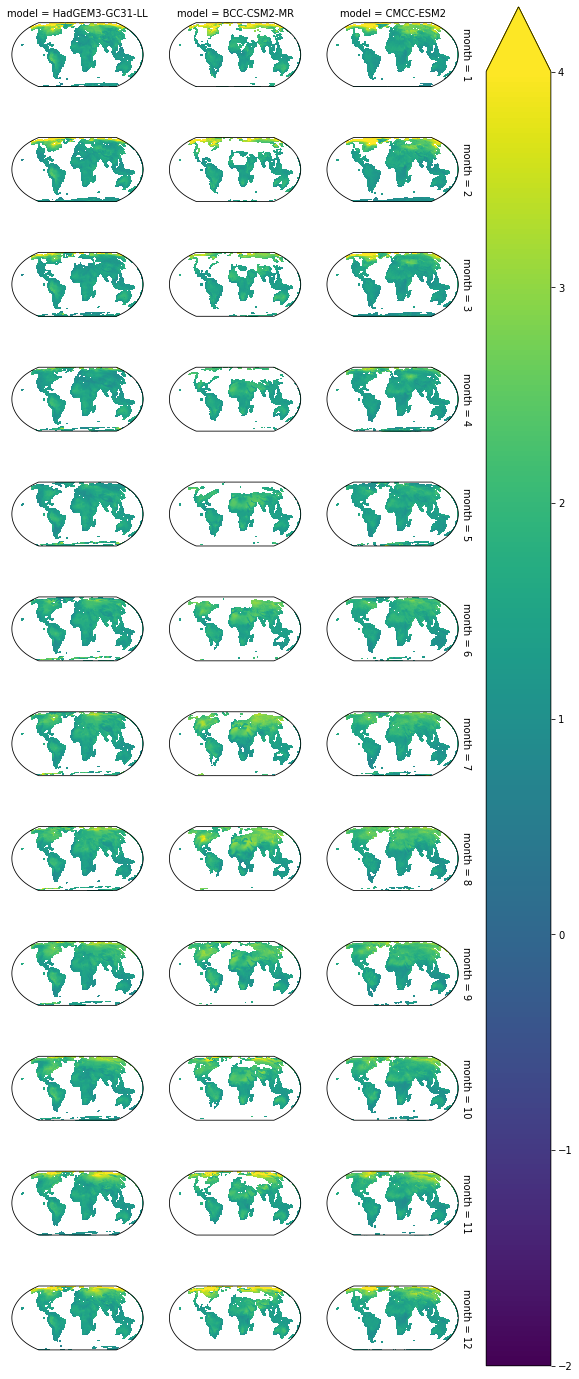

In [133]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

map_proj = ccrs.EqualEarth()


ds_monthly_trends.where(ds_monthly_trends.sel(linregress="rvalue")>0.5).sel(linregress="slope").plot(
    row="month",
    col="model",
    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": map_proj},
    figsize=(10, 25),
    vmin=-2, vmax=4,
)

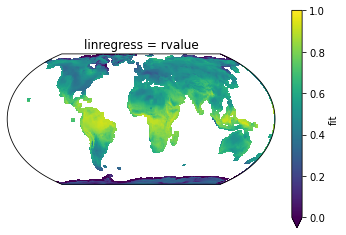

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr

map_proj = ccrs.EqualEarth()
ds_monthly_trends = xr.open_dataset("ds_monthly_trends.nc").rename(__xarray_dataarray_variable__="fit")
ds_monthly_trends.fit.sel(linregress="rvalue").median('model').min("month").plot(
    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": map_proj},
    vmin=0, vmax=1, cmap='viridis'
    
)
plt.savefig("../results/gsat_utci_rvalue_mmmed_minmonth.png")

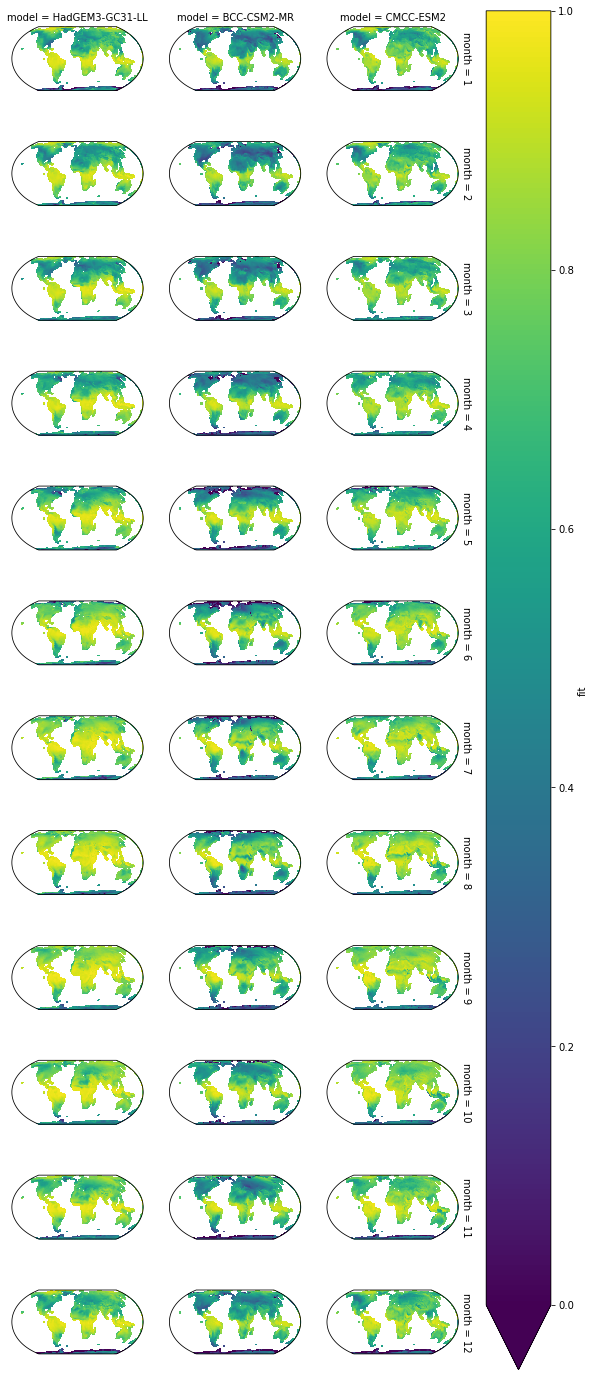

In [16]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr

map_proj = ccrs.EqualEarth()
ds_monthly_trends = xr.open_dataset("ds_monthly_trends.nc").rename(__xarray_dataarray_variable__="fit")
ds_monthly_trends.fit.sel(linregress="rvalue").plot(
    col="model", row="month",
    figsize=(10,25),
    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": map_proj},
    vmin=0, vmax=1, cmap='viridis'
    
)
plt.savefig("../results/gsat_utci_rvalue.png")